# Metody Obliczeniowe w Nauce i Technice
## Laboratorium 13
### Minimalizacja funkcji
#### Mateusz Surjak

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import math
import random
from scipy.optimize import dual_annealing

**Algorytm symulowanego wyżarzania** jest to rodzaj algorytmu heurystycznego przeszukującego przestrzeń alternatywnych rozwiązań problemu w celu wyszukania rozwiązań najlepszych. Służy do przybliżonego znajdowania globalnego ekstremum funkcji zadanej na dyskretnej przesrzeni stanów.

Funkcje generujące punkty

In [4]:
def generate_points_uniform(n, size):
    return np.random.uniform((0, 0), (size, size), (n, 2))
    
def generate_points_normal(n, size):
    mu=(size//2, size//2)
    sigma=(5 * np.identity(2))
    return np.random.multivariate_normal(mu, sigma, n)

def generate_seperated(n, size):
    points = np.zeros((n, 2))
    possible_places = [x for x in range(0, 25)]
    sigma=(5 * np.identity(2))
    for i in range(9):
        place = random.choice(possible_places)
        possible_places.remove(place)
        for k in range((i * n) // 9, ((i+1) * n) // 9):
            curr_mu = ((size / 5) * (place // 5) + size/10, (size / 5) * (place % 5) + size/10)
            points[k] = np.random.multivariate_normal(curr_mu, sigma, 1)
    np.random.shuffle(points)
    return points


Na poczatku wytłumaczę idee algorytmu:
- funkcja dual_annealing przyjmuje argument bounds - jest to tablica przedziałów, wymyśliłem że można przekazać do tej funkcji n takich samych przedziałów (bo mamy n punktów).
- funkcja dual_annealing na wejściu do funkcji f losuje sama jakiś punkt z każdego przedziału
- więc na wejściu do funkcji f mamy n punktów (każdy wylowowany z tego samego przedziału)
- punkty indeksuję od 0 do n-1 po czym je sortuje - robię to w celu aby każdy punkt z funkcji f odpowiadał punktowi w tablicy punktów wylosowanych z rozkładu (np. jednostajnego) - dzięki temu posortowana tablica daje nam sekwencje punktów w kolejności do TSP.
- dla seksencji posortowanych punktów liczę długość trasy która jest rezultatem funkcji f (funkcji minimalizacyjnej) - ścieżka wiedzie od punktu i-tego do i+1-ego

Stworzyłem klasę rozwiązującą problem komiwojażera

In [5]:
class Simulated_Annealing: 

    """
    n - liczba punktów
    size - zakres z jakiego mają być losowane punkty - (0, size)
    dist - rozkład
    """
    def __init__(self,n,size,dist, consecutive_swap = False, arbitrary_swap = False):
        self.n = n
        self.size = size
        if dist == 'normal':
            self.points = generate_points_normal(self.n,self.size)
        elif dist == 'uniform':
            self.points = generate_points_uniform(self.n,self.size)
        else:
            self.points = generate_seperated(self.n,self.size)
            
        self.consecutive_swap = consecutive_swap
        self.arbitrary_swap = arbitrary_swap
        self.values = []
    
    def set_arbitrary_swap(self):
        self.arbitrary_swap = True
        
    def del_arbitrary_swap(self):
        self.arbitrary_swap = False
        
    def set_consecutive_swap(self):
        self.consecutive_swap = True
        
    def del_consecutive_swap(self):
        self.consecutive_swap = False
        
    @staticmethod
    def vector_cost(p1,p2):
        return math.sqrt((p2[0]-p1[0])**2 + (p2[1]-p1[1])**2)
    
    """
    Funkcja zwracająca koszt ścieżki
    """
    def get_cost(self,tab):
        cost = 0
        for i,x in enumerate(tab):
            p1 = self.points[x[0]]
            if i < self.n-1:
                tmp = tab[i+1]
            else:
                tmp = tab[0]
            p2 = self.points[tmp[0]]
            cost += Simulated_Annealing.vector_cost(p1,p2)
        self.values.append(cost)
        return cost
    
    """
    Funkcja która zwraca koszt trasy
    """
    def f(self,x):
        if self.arbitrary_swap:
            r1 = random.randint(0,self.n-1)
            r2 = random.randint(0,self.n-1)
            while r1 == r2:
                r2 = random.randint(0,self.n-1)
            x[r1],x[r2] = x[r2],x[r1]
        elif self.consecutive_swap:
            r1 = random.randint(0,self.n-1)
            r2 = (r1+1)%self.n
            x[r1],x[r2] = x[r2],x[r1]
        
        tab = []
        for i,xi in enumerate(x):
            tab.append((i,xi))
        tab = sorted(tab, key=lambda x: x[1])
        return self.get_cost(tab)
    
    """
    Pomocnicza funkcja - rysowanie wykresu punktów i ścieżki między nimi
    """
    def draw_plot(self,res,val):
        x_number_list = []
        y_number_list = []
        for i,x in res:
            p = self.points[i]
            x_number_list.append(p[0])
            y_number_list.append(p[1])
        first = res[0][0]

        x_number_list.append(self.points[first][0])
        y_number_list.append(self.points[first][1])

        plt.plot(x_number_list, y_number_list,marker = 'o')
        plt.plot(x_number_list, y_number_list, linewidth=1)
        if self.arbitrary_swap:
            plt.title(f"Arbitrary swap TSP - length = {val}")
        elif self.consecutive_swap:
            plt.title(f"Consecutive swap TSP - length = {val}")
        else:
            plt.title(f"TSP - length = {val}")

        plt.xlabel("X")
        plt.ylabel("Y")
        plt.show()
        
    """
    Główna funkcja rozwiązująca problem
    """
    def annealing(self):
        self.values = []
        if self.arbitrary_swap and self.consecutive_swap:
            print("Arbitrary swap and Consecutive swap - choose one")
            return
        lw = [0] * self.n
        up = [10] * self.n

        a  = list(zip(lw, up))

        ret = dual_annealing(self.f, bounds=a)

        response = []

        for i,x in enumerate(ret.x):
            response.append((i,x))

        response = sorted(response, key=lambda x: x[1])

        self.draw_plot(response,ret.fun)   
        
    """
    Wizualizacja wykresu długości drogi dla kolejnych kroków
    """
    def path_length_visualization(self):
        plt.plot(self.values,linewidth=.1)
        plt.show()


### Przedstaw wizualizację otrzymanego rozwiązania dla 3 różnych wartości n oraz 3 różnych układów punktów w 2D

- pierwszy wykres - rozkład jednostajny
- drugi wyhres - rozkład normalny
- trzeci wykres - 9 odseperowanych grup punktów
- n = 20

In [6]:
an = Simulated_Annealing(20,100,'uniform')
an1 = Simulated_Annealing(20,100,'normal')
an2 = Simulated_Annealing(20,100,'------')
an.annealing()
an1.annealing()
an2.annealing()

NameError: name 'np' is not defined

- pierwszy wykres - rozkład jednostajny
- drugi wyhres - rozkład normalny
- trzeci wykres - 9 odseperowanych grup punktów
- n = 30

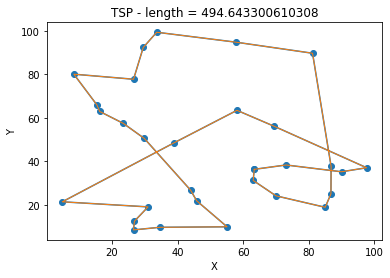

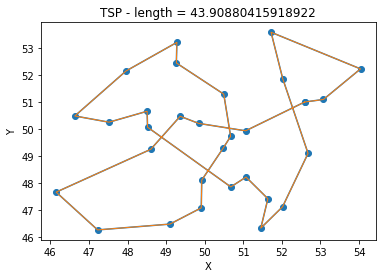

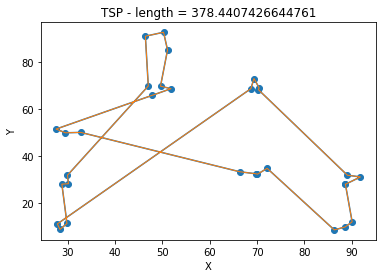

In [5]:
an = Simulated_Annealing(30,100,'uniform')
an1 = Simulated_Annealing(30,100,'normal')
an2 = Simulated_Annealing(30,100,'------')
an.annealing()
an1.annealing()
an2.annealing()

- pierwszy wykres - rozkład jednostajny
- drugi wyhres - rozkład normalny
- trzeci wykres - 9 odseperowanych grup punktów
- n = 60

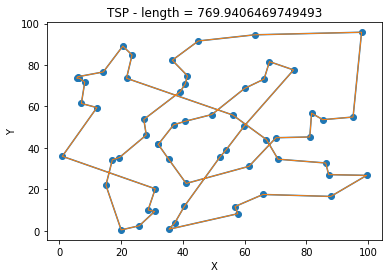

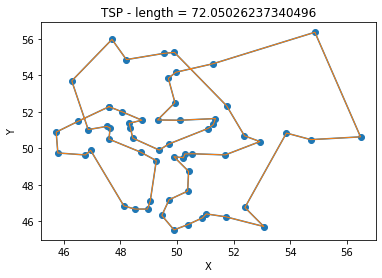

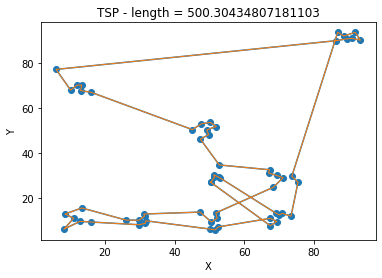

In [14]:
an = Simulated_Annealing(60,100,'uniform')
an1 = Simulated_Annealing(60,100,'normal')
an2 = Simulated_Annealing(60,100,'------')
an.annealing()
an1.annealing()
an2.annealing()

### Zbadaj wpływ sposobu generacji sąsiedniego stanu na zbieżność procesu optymalizacji.
- consecutive swap - zamiana kolejności losowej pary połączonych wierzchołków w ścieżce
- arbitrary swap - zamiana dwóch losowych wierzchołków w ścieżce

#### Dla
- 20 punktów 
- 9 grup

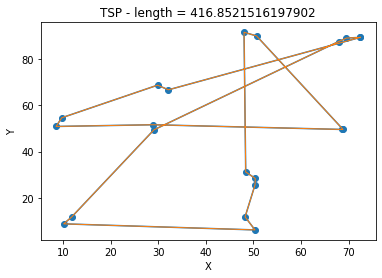

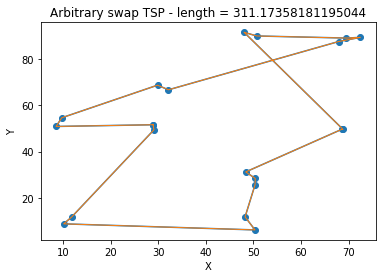

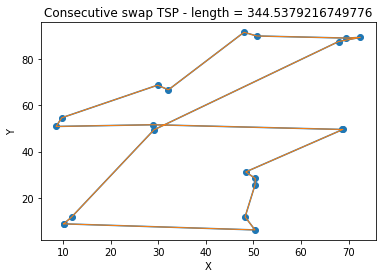

In [7]:
an = Simulated_Annealing(20,100,'-----')

an.annealing()

an.set_arbitrary_swap()
an.annealing()

an.del_arbitrary_swap()
an.set_consecutive_swap()
an.annealing()


#### Dla
- 30 punktów
- rozkład normalny

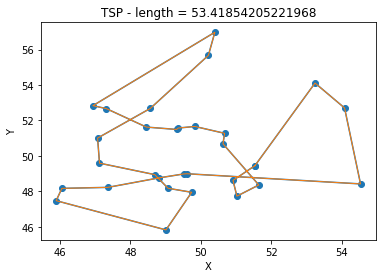

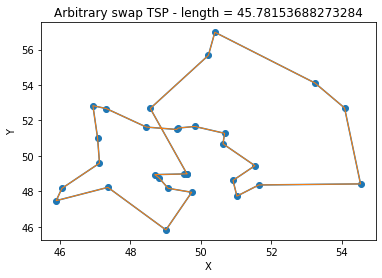

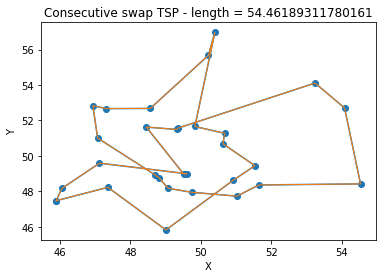

In [18]:
an = Simulated_Annealing(30,100,'normal')

an.annealing()

an.set_arbitrary_swap()
an.annealing()

an.del_arbitrary_swap()
an.set_consecutive_swap()
an.annealing()


#### Dla
- 30 punktów
- rozkład jednostajny

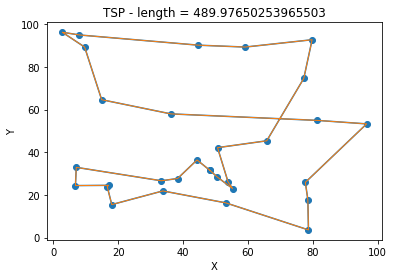

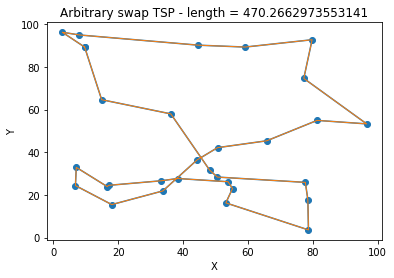

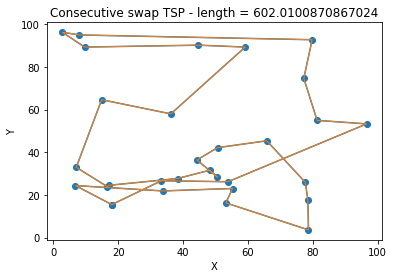

In [19]:
an = Simulated_Annealing(30,100,'uniform')

an.annealing()

an.set_arbitrary_swap()
an.annealing()

an.del_arbitrary_swap()
an.set_consecutive_swap()
an.annealing()

## Wnioski:
- Wykonałem wiele testów, *arbitrary swap* praktycznie w każdym z nich okazywał się dawać krótsza trasę niż *consecutive swap*

# Przedstaw wizualizację działania procedury minimalizującej funkcję celu

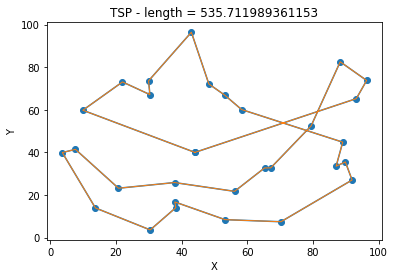

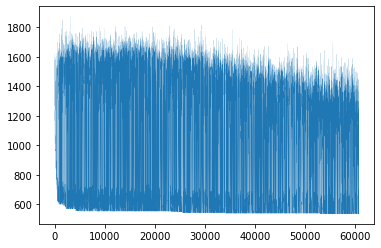

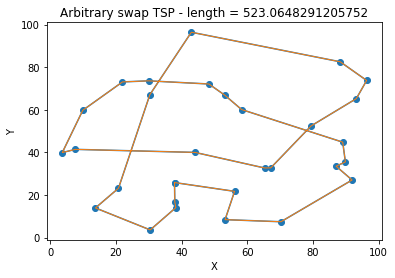

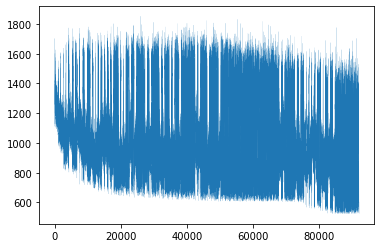

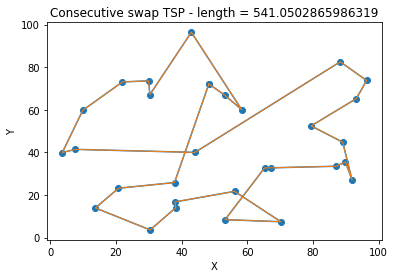

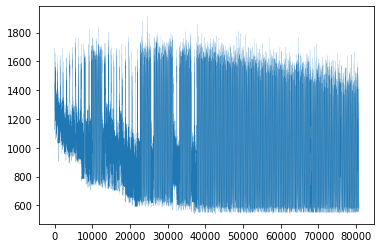

In [8]:
an = Simulated_Annealing(30,100,'uniform')

an.annealing()
an.path_length_visualization()

an.set_arbitrary_swap()
an.annealing()
an.path_length_visualization()

an.del_arbitrary_swap()
an.set_consecutive_swap()
an.annealing()
an.path_length_visualization()

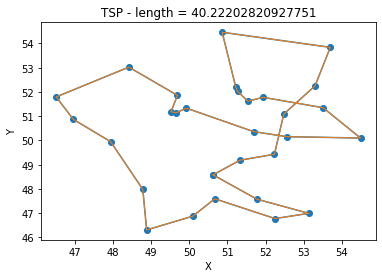

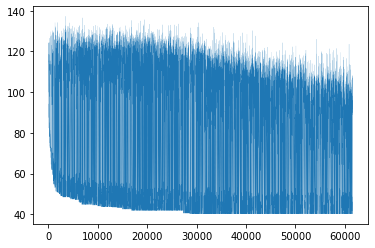

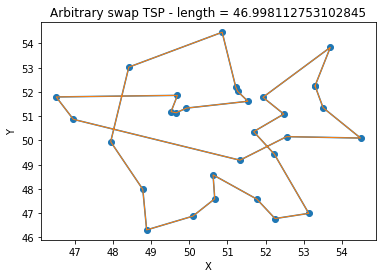

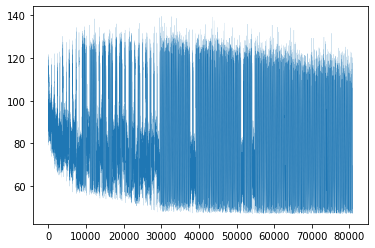

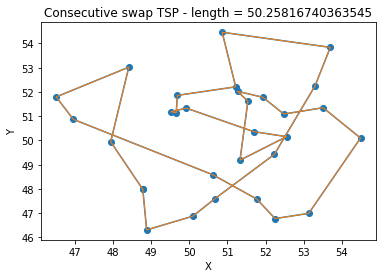

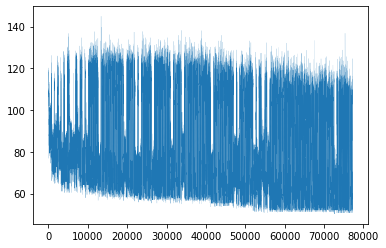

In [24]:
an = Simulated_Annealing(30,100,'normal')

an.annealing()
an.path_length_visualization()

an.set_arbitrary_swap()
an.annealing()
an.path_length_visualization()

an.del_arbitrary_swap()
an.set_consecutive_swap()
an.annealing()
an.path_length_visualization()

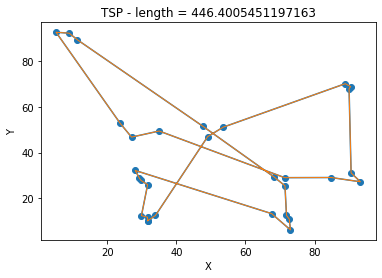

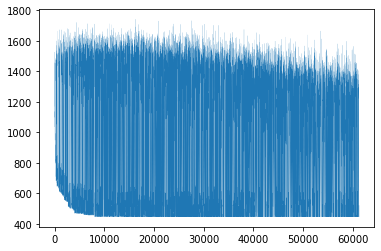

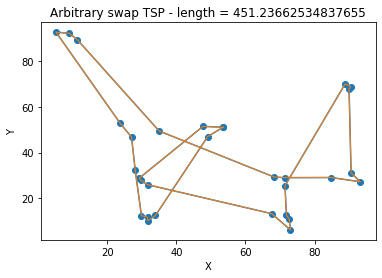

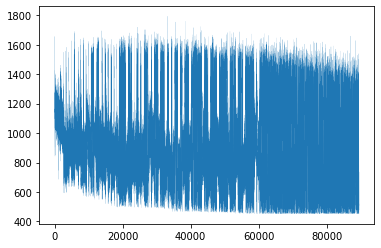

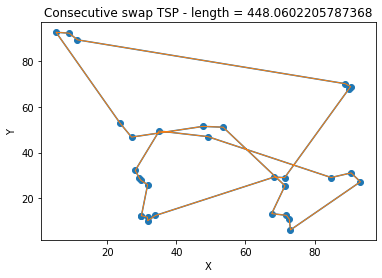

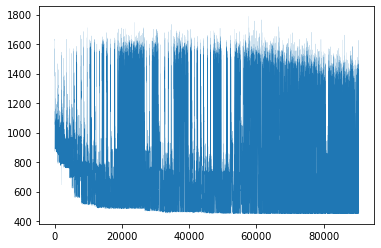

In [26]:
an = Simulated_Annealing(30,100,'------')

an.annealing()
an.path_length_visualization()

an.set_arbitrary_swap()
an.annealing()
an.path_length_visualization()

an.del_arbitrary_swap()
an.set_consecutive_swap()
an.annealing()
an.path_length_visualization()

## Wnioski:
- można zauważyć że w każdym z przypadków wykres zbiega do wartości najmniejszej (w początkowych fazach wykresu wartości minimalne są wysoko nad osią x, wraz z upływem iteracji wartości często stykają się z osią x)
- na niektórych wykresach wydać gęstszy pas zbiegający do wartości minimalnej, jest to cecha algorytmu - gdy algorytm znajduje wartość dobrą na dany monent to próbuje zrobić żeby była jeszcze lepsza i delikatnie modyfikuje dane wejściowe, co powoduje że często wartość funkcji w kroku i+1 jest bliska wartości w kroku i.